# Set Path

In [71]:
import numpy as np
import os
import random
import time
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
base_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'data', '100'))

class_dirs = ['immune', 'tumour', 'stromal', 'other']

def ensure_dir_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

random.seed(3888)
np.random.seed(3888)

# Resizing

In [41]:
def load_resize(img_path, size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(size)
    return np.array(img)

# Split and train

In [ ]:
def get_image_paths(base_path, class_dirs):
    image_paths = {'tumour': [], 'immune': [], 'stromal': [], 'other': []}
    for class_dir in class_dirs:
        dir_path = os.path.join(base_path, class_dir)
        if os.path.isdir(dir_path):
            for file_name in os.listdir(dir_path):
                if file_name.endswith(".png"):
                    image_paths[class_dir].append(os.path.join(dir_path, file_name))
    return image_paths

In [ ]:
image_paths = get_image_paths(base_path, class_dirs)

all_images = []
all_labels = []

for label, paths in image_paths.items():
    for img_path in paths:
        all_images.append(img_path)
        all_labels.append(label)

# Shuffle the data
data = list(zip(all_images, all_labels))
random.shuffle(data)

all_images, all_labels = zip(*data)

# Splitting data into training, validation, and testing
training_size = 2500
val_size = 500
testing_size = 1000

X_train = np.array([load_resize(img_path) for img_path in all_images[:training_size]])
X_val = np.array([load_resize(img_path) for img_path in all_images[training_size:training_size+val_size]])
X_test = np.array([load_resize(img_path) for img_path in all_images[training_size+val_size:training_size+val_size+testing_size]])

# Encoding labels
le = LabelEncoder()
y_train = le.fit_transform(all_labels[:training_size])
y_val = le.transform(all_labels[training_size:training_size+val_size])
y_test = le.transform(all_labels[training_size+val_size:training_size+val_size+testing_size])


In [46]:
def build_model():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Model Training

In [47]:
model = build_model()
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

y_pred = np.argmax(model.predict(X_test), axis=1)

report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

results_row = {
    "Model": "original",
    "Accuracy": accuracy,
    "Precision_tumour": report["tumour"]["precision"],
    "Precision_immune": report["immune"]["precision"],
    "Precision_stromal": report["stromal"]["precision"],
    "Precision_other": report["other"]["precision"],
    "F1_score_macro": report["macro avg"]["f1-score"]
}

csv_path = "model_evaluation_summary.csv"
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    updated_df = pd.concat([existing_df, pd.DataFrame([results_row])], ignore_index=True)
else:
    updated_df = pd.DataFrame([results_row])

updated_df.to_csv(csv_path, index=False)

print(updated_df.tail(1))

model.save("cnn_original.h5")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 394s 10s/step - accuracy: 0.4216 - loss: 1.3473 - val_accuracy: 0.2420 - val_loss: 4.9457
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 388s 10s/step - accuracy: 0.5369 - loss: 1.0574 - val_accuracy: 0.2420 - val_loss: 3.3286
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 357s 9s/step - accuracy: 0.5770 - loss: 0.9996 - val_accuracy: 0.2800 - val_loss: 2.2325
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 305s 8s/step - accuracy: 0.5789 - loss: 0.9724 - val_accuracy: 0.2760 - val_loss: 1.6995
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 289s 7s/step - accuracy: 0.5949 - loss: 0.9652 - val_accuracy: 0.4380 - val_loss: 1.3152
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 395s 10s/step - accuracy: 0.6139 - loss: 0.9291 - val_accuracy: 0.4120 - val_loss: 1.3179
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 381s 10s/step - accuracy: 0.6461 - loss: 0.9013 - val_accuracy: 0.5400 - val_loss: 1.1299
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 340s 8s/step - accuracy: 0.6359 - loss: 0.9260 - val_accuracy: 0.5100

      Model  Accuracy  Precision_tumour  Precision_immune  Precision_stromal  \
0  original     0.651          0.638484          0.685106           0.577778   

   Precision_other  F1_score_macro  
0         0.756579        0.644298  


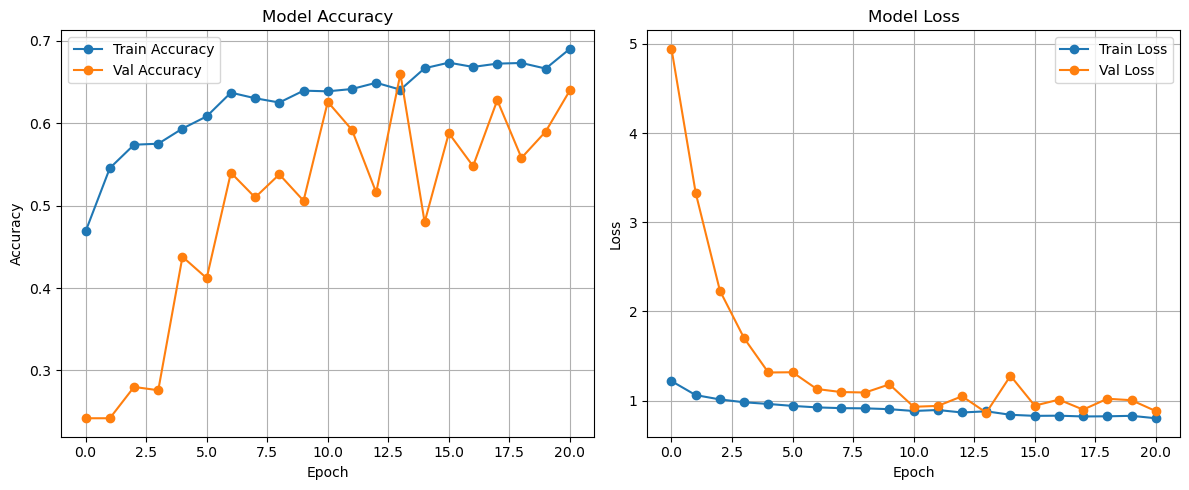

In [48]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()